In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'train (2).csv'
data = pd.read_csv(file_path)

# Display initial dataset information
print("Initial Dataset Info:")
print(data.info())
print("\nStatistical Summary:\n", data.describe())

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   vidid      14999 non-null  object
 1   adview     14999 non-null  int64 
 2   views      14999 non-null  object
 3   likes      14999 non-null  object
 4   dislikes   14999 non-null  object
 5   comment    14999 non-null  object
 6   published  14999 non-null  object
 7   duration   14999 non-null  object
 8   category   14999 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.0+ MB
None

Statistical Summary:
              adview
count  1.499900e+04
mean   2.107791e+03
std    5.237711e+04
min    1.000000e+00
25%    1.000000e+00
50%    2.000000e+00
75%    6.000000e+00
max    5.429665e+06


In [ ]:
# Handle missing values by converting columns to numeric and dropping NaNs
data['views'] = pd.to_numeric(data['views'], errors='coerce')
data['likes'] = pd.to_numeric(data['likes'], errors='coerce')
data['dislikes'] = pd.to_numeric(data['dislikes'], errors='coerce')
data['comment'] = pd.to_numeric(data['comment'], errors='coerce')

# Drop rows with NaN values
data.dropna(inplace=True)

# Parse 'duration' from ISO 8601 to total seconds
def parse_duration(duration):
    hours = minutes = seconds = 0
    time_part = duration.replace('PT', '')

    if 'H' in time_part:
        hours, time_part = time_part.split('H')
        hours = int(hours)
    if 'M' in time_part:
        minutes, time_part = time_part.split('M')
        minutes = int(minutes)
    if 'S' in time_part:
        seconds = int(time_part.replace('S', ''))

    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds

data['duration'] = data['duration'].apply(parse_duration)

In [ ]:
# Encode 'category' using one-hot encoding
data = pd.get_dummies(data, columns=['category'], drop_first=True)

# Drop 'vidid' and 'published' as they're not useful for prediction
data.drop(['vidid', 'published'], axis=1, inplace=True)

# Feature engineering: create new features based on existing ones
data['likes_views_ratio'] = data['likes'] / data['views']
data['dislikes_views_ratio'] = data['dislikes'] / data['views']
data['comments_views_ratio'] = data['comment'] / data['views']

# Handle infinite values resulting from division by zero
data.replace([np.inf, -np.inf], 0, inplace=True)

# Detect and remove outliers in the target variable 'adview'
# Removing entries with adviews beyond 99th percentile
q_high = data['adview'].quantile(0.99)
data = data[data['adview'] <= q_high]


In [ ]:
# Use PowerTransformer to handle skewness in the target variable 'adview'
pt = PowerTransformer()
data['adview'] = pt.fit_transform(data[['adview']])

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
features = data.drop('adview', axis=1)
scaled_features = scaler.fit_transform(features)

# Prepare the final dataset
X = scaled_features
y = data['adview'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the complex ANN model with multiple Dense layers
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(units=256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))  # Add dropout to prevent overfitting

# Second hidden layer
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.4))

# Third hidden layer
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))

# Fourth hidden layer
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

# Fifth hidden layer
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1, activation='linear'))  # Linear activation for regression tasks

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
# Define callbacks for early stopping, learning rate adjustment, and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_ann_model.keras', save_best_only=True, monitor='val_loss')


# Learning rate scheduler to reduce the learning rate if the model isn't improving
def lr_schedule(epoch, lr):
    if epoch > 20:
        return lr * 0.8
    elif epoch > 10:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


In [ ]:
# Train the model with validation split and callbacks
history = model.fit(X_train, y_train, validation_split=0.2, epochs=150, batch_size=32, callbacks=[early_stopping, model_checkpoint, lr_scheduler])

# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

# Make predictions on the test data
y_pred = model.predict(X_test)

# Reverse the PowerTransform on the predictions to get the actual scale
y_test_actual = pt.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = pt.inverse_transform(y_pred)

# Check for NaN values in y_test_actual and y_pred_actual
print("NaNs in y_test_actual:", np.isnan(y_test_actual).sum())
print("NaNs in y_pred_actual:", np.isnan(y_pred_actual).sum())

# Remove NaNs from y_test_actual and y_pred_actual
valid_idx = ~np.isnan(y_test_actual) & ~np.isnan(y_pred_actual)
y_test_actual = y_test_actual[valid_idx]
y_pred_actual = y_pred_actual[valid_idx]

# Calculate and display error metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Epoch 1/150
290/290 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.0066 - mae: 0.9244 - val_loss: 0.9851 - val_mae: 0.9087 - learning_rate: 0.0010
Epoch 2/150
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9923 - mae: 0.9155 - val_loss: 0.9870 - val_mae: 0.9042 - learning_rate: 0.0010
Epoch 3/150
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9988 - mae: 0.9161 - val_loss: 0.9799 - val_mae: 0.9004 - learning_rate: 0.0010
Epoch 4/150
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9993 - mae: 0.9155 - val_loss: 0.9635 - val_mae: 0.8986 - learning_rate: 0.0010
Epoch 5/150
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9744 - mae: 0.9060 - val_loss: 0.9440 - val_mae: 0.8770 - learning_rate: 0.0010
Epoch 6/150
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9586 - mae: 0.8953 - val_loss: 0.9393 - val_mae: 0.8780 - learning_rate: 0.0010
Epoch 7/150
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9564 - mae: 0.8901 - val_loss: 0.9219 - val_mae: 0.8690 - learning_rate: 0.0010

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


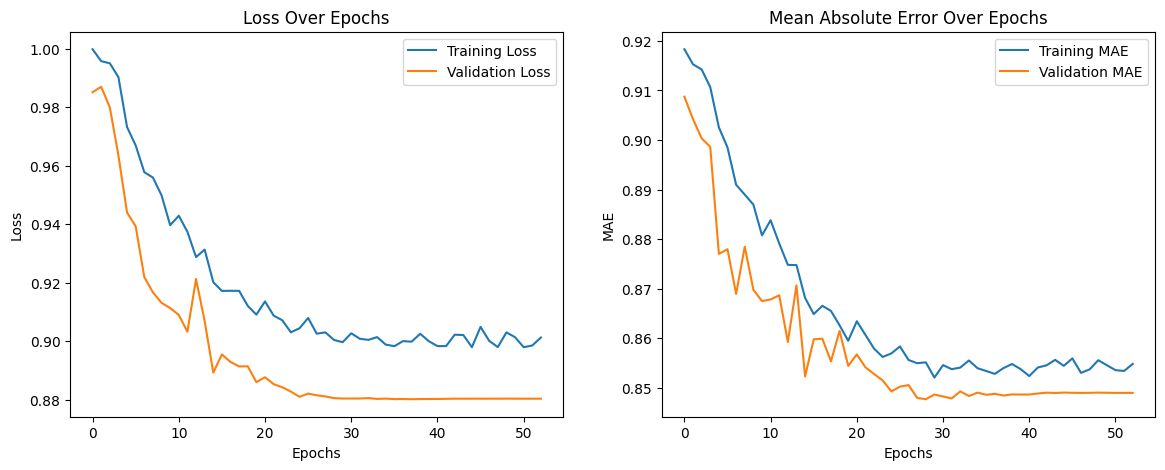

In [ ]:

# Plotting the loss and MAE over epochs
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


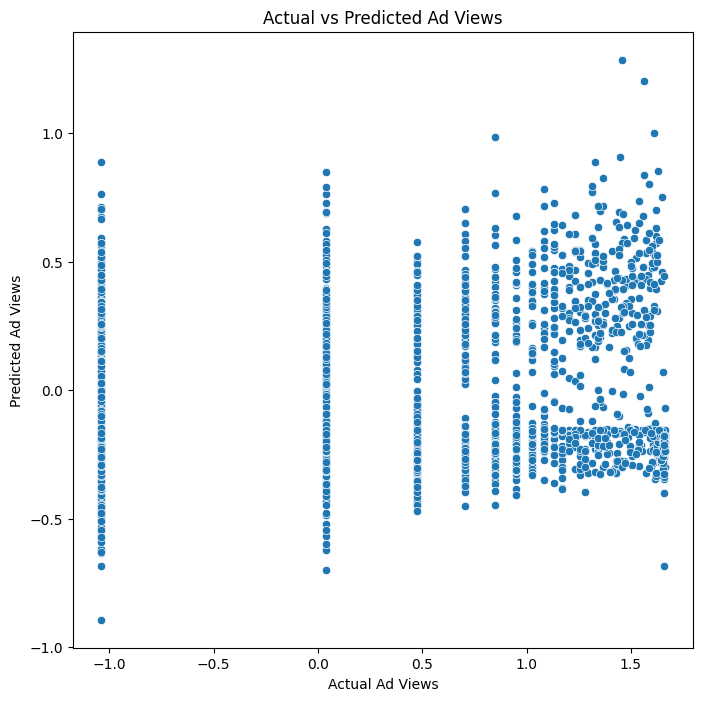

In [ ]:
# Visualize predictions vs actual values
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test_actual.flatten(), y=y_pred_actual.flatten())
plt.xlabel('Actual Ad Views')
plt.ylabel('Predicted Ad Views')
plt.title('Actual vs Predicted Ad Views')
plt.show()


In [ ]:
# Save the final model
model.save('final_ann_youtube_adview_prediction_model.h5')

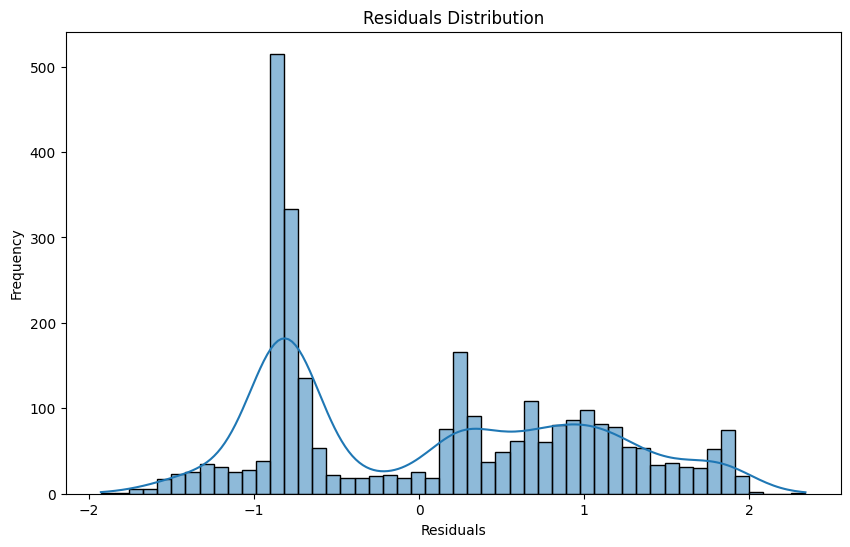

In [ ]:
# Additional evaluation: Residuals plot
residuals = y_test_actual.flatten() - y_pred_actual.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


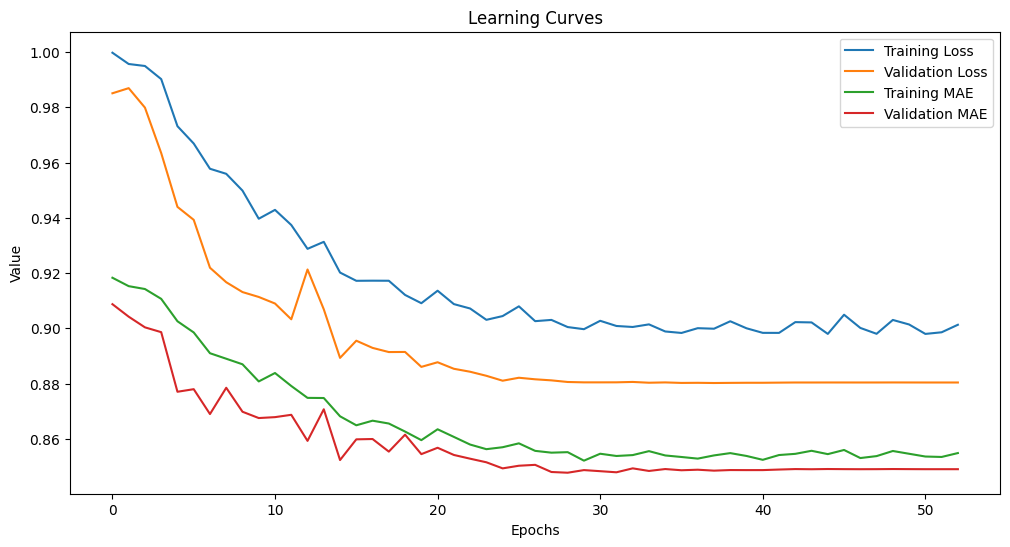

In [ ]:
# Additional evaluation: Learning curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


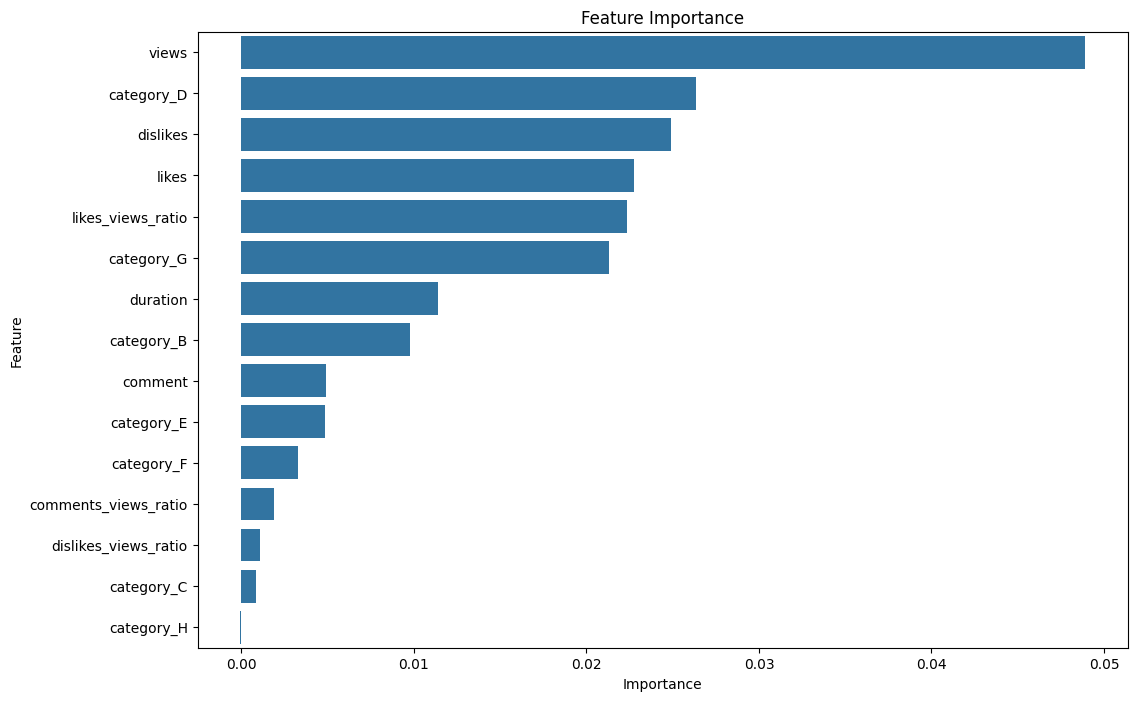

In [ ]:
# Custom Feature Importance Calculation for Neural Network
from sklearn.metrics import mean_squared_error

# Function to calculate the MSE on the test set
def score_func(model, X, y):
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)

# Calculate the baseline MSE
baseline_mse = score_func(model, X_test, y_test_actual)

# Initialize a dictionary to hold the importances
importances = {}

# Iterate through each feature
for i in range(X_test.shape[1]):
    # Shuffle the values in the current feature
    X_test_permuted = X_test.copy()
    np.random.shuffle(X_test_permuted[:, i])

    # Calculate the MSE with the shuffled feature
    permuted_mse = score_func(model, X_test_permuted, y_test_actual)

    # Calculate the importance as the difference in MSE
    importances[features.columns[i]] = permuted_mse - baseline_mse

# Convert the importances dictionary to a sorted list
importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# Convert to a DataFrame for easier visualization
importance_df = pd.DataFrame(importances, columns=['Feature', 'Importance'])

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()
